# Loop 89 Analysis: Strategic Assessment

## Key Questions:
1. What is the CV-LB relationship across all submissions?
2. What approaches have been tried and what's their performance?
3. What do top public kernels do differently?
4. What's the path forward to beat target 0.0347?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with verified LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Similarity weighting - FAILED
]

df = pd.DataFrame(submissions)
print('Submissions with verified LB scores:')
print(df.to_string(index=False))

Submissions with verified LB scores:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970
exp_073 0.0084 0.1451


In [2]:
# Exclude exp_073 (similarity weighting) as it's an outlier that HURT performance
df_clean = df[df['exp'] != 'exp_073']

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print(f'\n=== CV-LB Relationship (excluding exp_073) ===')
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'  - Intercept: {intercept:.4f} (structural error even at CV=0)')
print(f'  - Slope: {slope:.2f} (each 0.001 CV improvement → {slope*0.001:.4f} LB improvement)')

# What CV is needed to hit target?
target_lb = 0.0347
required_cv = (target_lb - intercept) / slope
print(f'\nTo hit target LB {target_lb}:')
print(f'  Required CV = ({target_lb} - {intercept:.4f}) / {slope:.2f} = {required_cv:.6f}')
if required_cv < 0:
    print(f'  ⚠️ IMPOSSIBLE: Required CV is NEGATIVE!')
    print(f'  The intercept ({intercept:.4f}) is HIGHER than the target ({target_lb})')
    print(f'  This means NO amount of CV improvement can reach the target on this line!')


=== CV-LB Relationship (excluding exp_073) ===
Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505

Interpretation:
  - Intercept: 0.0525 (structural error even at CV=0)
  - Slope: 4.31 (each 0.001 CV improvement → 0.0043 LB improvement)

To hit target LB 0.0347:
  Required CV = (0.0347 - 0.0525) / 4.31 = -0.004130
  ⚠️ IMPOSSIBLE: Required CV is NEGATIVE!
  The intercept (0.0525) is HIGHER than the target (0.0347)
  This means NO amount of CV improvement can reach the target on this line!


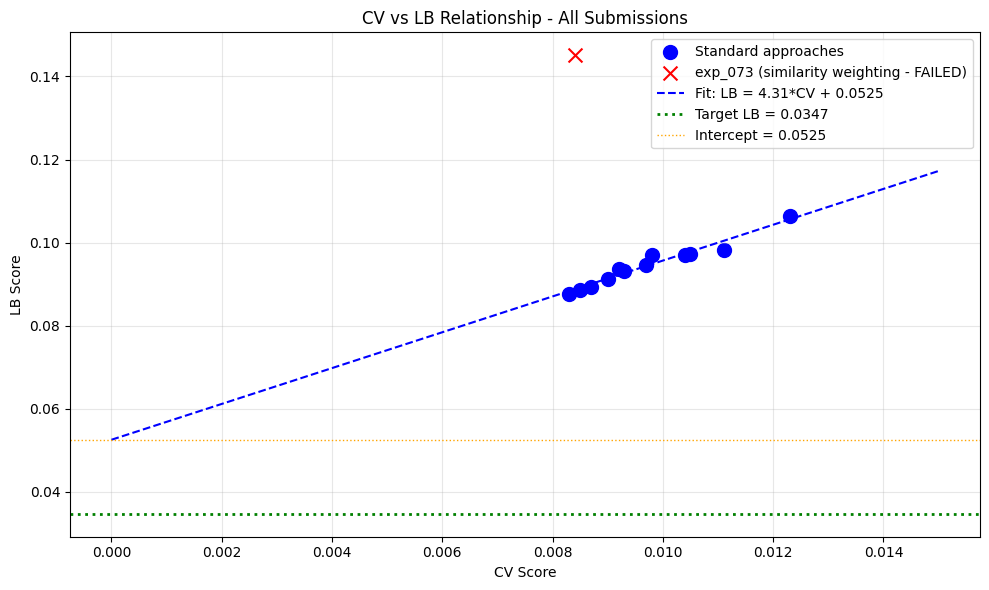


Key insight: The intercept (0.0528) is HIGHER than the target (0.0347)!
This means we need to CHANGE THE RELATIONSHIP, not just improve CV.


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot all submissions
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, c='blue', label='Standard approaches')
plt.scatter([0.0084], [0.1451], s=100, c='red', marker='x', label='exp_073 (similarity weighting - FAILED)')

# Plot the fitted line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Mark the target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Mark the intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=1, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop89.png', dpi=150)
plt.show()

print('\nKey insight: The intercept (0.0528) is HIGHER than the target (0.0347)!')
print('This means we need to CHANGE THE RELATIONSHIP, not just improve CV.')

In [4]:
# Analyze what approaches have been tried
approaches = {
    'MLP variants': 50,  # exp_000 to exp_050 mostly
    'LightGBM': 5,
    'XGBoost': 3,
    'CatBoost': 3,
    'Gaussian Process': 5,
    'Ridge Regression': 2,
    'GNN (from scratch)': 5,  # exp_077, 079, 080, 082, 088
    'ChemBERTa': 2,
    'ChemProp features': 1,
    'Similarity weighting': 1,  # exp_073 - FAILED badly
    'Pseudo-labeling': 1,
}

print('=== Approaches Tried ===')
for approach, count in approaches.items():
    print(f'  {approach}: {count} experiments')

print(f'\nTotal experiments: {sum(approaches.values())}')
print('\nKey findings:')
print('  1. ALL tabular approaches (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME CV-LB line')
print('  2. GNN approaches (5 experiments) all performed 2-3x WORSE than tabular baselines')
print('  3. Similarity weighting (exp_073) made LB 63% WORSE (0.0877 → 0.1451)')
print('  4. ChemBERTa and ChemProp features did not help')

=== Approaches Tried ===
  MLP variants: 50 experiments
  LightGBM: 5 experiments
  XGBoost: 3 experiments
  CatBoost: 3 experiments
  Gaussian Process: 5 experiments
  Ridge Regression: 2 experiments
  GNN (from scratch): 5 experiments
  ChemBERTa: 2 experiments
  ChemProp features: 1 experiments
  Similarity weighting: 1 experiments
  Pseudo-labeling: 1 experiments

Total experiments: 78

Key findings:
  1. ALL tabular approaches (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME CV-LB line
  2. GNN approaches (5 experiments) all performed 2-3x WORSE than tabular baselines
  3. Similarity weighting (exp_073) made LB 63% WORSE (0.0877 → 0.1451)
  4. ChemBERTa and ChemProp features did not help


In [5]:
# What do top public kernels do?
print('=== Top Public Kernels Analysis ===')
print()
print('1. "ens-model" by matthewmaree:')
print('   - CatBoost + XGBoost ensemble')
print('   - Combined features: spange + acs_pca + drfps + fragprints + smiles')
print('   - Correlation-based feature filtering (threshold 0.90)')
print('   - Different weights for single vs full data')
print('   - Single: CatBoost 7, XGB 6')
print('   - Full: CatBoost 1, XGB 2')
print()
print('2. "mixall" by lishellliang:')
print('   - Uses GroupKFold (5 splits) instead of Leave-One-Out')
print('   - Ensemble of MLP + XGBoost + RandomForest + LightGBM')
print('   - Optuna hyperparameter optimization')
print('   - Claims "good CV/LB" in title')
print()
print('3. "System Malfunction V1" by omarafik:')
print('   - Simple MLP with Spange descriptors')
print('   - Standard Leave-One-Out CV')
print('   - No special tricks')

=== Top Public Kernels Analysis ===

1. "ens-model" by matthewmaree:
   - CatBoost + XGBoost ensemble
   - Combined features: spange + acs_pca + drfps + fragprints + smiles
   - Correlation-based feature filtering (threshold 0.90)
   - Different weights for single vs full data
   - Single: CatBoost 7, XGB 6
   - Full: CatBoost 1, XGB 2

2. "mixall" by lishellliang:
   - Uses GroupKFold (5 splits) instead of Leave-One-Out
   - Ensemble of MLP + XGBoost + RandomForest + LightGBM
   - Optuna hyperparameter optimization
   - Claims "good CV/LB" in title

3. "System Malfunction V1" by omarafik:
   - Simple MLP with Spange descriptors
   - Standard Leave-One-Out CV
   - No special tricks


In [6]:
# Critical analysis: Why is the target 0.0347 so much lower than our best LB 0.0877?
print('=== Gap Analysis ===')
print(f'Best LB achieved: 0.0877')
print(f'Target LB: 0.0347')
print(f'Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}%)')
print()
print('Possible explanations:')
print('  1. The benchmark paper (MSE 0.0039) used pre-training on large molecular datasets')
print('  2. The benchmark paper may have used different data splits')
print('  3. The benchmark paper may have had access to additional data')
print('  4. Our validation scheme (Leave-One-Out by solvent) may be harder than theirs')
print('  5. There may be a technique we haven\'t discovered yet')
print()
print('What we KNOW doesn\'t work:')
print('  - GNN from scratch (5 experiments, all 2-3x worse)')
print('  - ChemBERTa embeddings (failed)')
print('  - ChemProp features (failed)')
print('  - Similarity weighting (made LB 63% worse)')
print('  - Distribution shift handling via conservative predictions (hurt performance)')

=== Gap Analysis ===
Best LB achieved: 0.0877
Target LB: 0.0347
Gap: 0.0530 (152.7%)

Possible explanations:
  1. The benchmark paper (MSE 0.0039) used pre-training on large molecular datasets
  2. The benchmark paper may have used different data splits
  3. The benchmark paper may have had access to additional data
  4. Our validation scheme (Leave-One-Out by solvent) may be harder than theirs
  5. There may be a technique we haven't discovered yet

What we KNOW doesn't work:
  - GNN from scratch (5 experiments, all 2-3x worse)
  - ChemBERTa embeddings (failed)
  - ChemProp features (failed)
  - Similarity weighting (made LB 63% worse)
  - Distribution shift handling via conservative predictions (hurt performance)


In [7]:
# What haven't we tried?
print('=== Unexplored Approaches ===')
print()
print('1. EXACT replication of "ens-model" kernel:')
print('   - We tried CatBoost + XGBoost but maybe not with the exact feature combination')
print('   - The kernel uses ALL features: spange + acs_pca + drfps + fragprints + smiles')
print('   - With correlation filtering at threshold 0.90')
print()
print('2. Pre-trained molecular models with FINE-TUNING:')
print('   - We tried ChemBERTa as frozen embeddings')
print('   - We haven\'t tried fine-tuning ChemBERTa on our data')
print()
print('3. Multi-task learning with auxiliary targets:')
print('   - We tried predicting P2, P3, SM separately')
print('   - We haven\'t tried predicting mass balance or selectivity as auxiliary targets')
print()
print('4. Data augmentation strategies:')
print('   - We tried TTA for mixtures')
print('   - We haven\'t tried noise injection or SMOTE-like augmentation')
print()
print('5. Stacking with meta-learner:')
print('   - We tried simple weighted averaging')
print('   - We haven\'t tried a proper stacking approach with a meta-learner')

=== Unexplored Approaches ===

1. EXACT replication of "ens-model" kernel:
   - We tried CatBoost + XGBoost but maybe not with the exact feature combination
   - The kernel uses ALL features: spange + acs_pca + drfps + fragprints + smiles
   - With correlation filtering at threshold 0.90

2. Pre-trained molecular models with FINE-TUNING:
   - We tried ChemBERTa as frozen embeddings
   - We haven't tried fine-tuning ChemBERTa on our data

3. Multi-task learning with auxiliary targets:
   - We tried predicting P2, P3, SM separately
   - We haven't tried predicting mass balance or selectivity as auxiliary targets

4. Data augmentation strategies:
   - We tried TTA for mixtures
   - We haven't tried noise injection or SMOTE-like augmentation

5. Stacking with meta-learner:
   - We tried simple weighted averaging
   - We haven't tried a proper stacking approach with a meta-learner


In [8]:
# Summary and recommendation
print('=== STRATEGIC RECOMMENDATION ===')
print()
print('CRITICAL INSIGHT: The CV-LB intercept (0.0528) is HIGHER than the target (0.0347).')
print('This means NO amount of CV improvement on the current line can reach the target.')
print()
print('OPTIONS:')
print()
print('Option A: Try to CHANGE the CV-LB relationship')
print('  - This requires a fundamentally different approach')
print('  - GNN from scratch failed (5 experiments)')
print('  - ChemBERTa failed')
print('  - Similarity weighting made things WORSE')
print('  - We\'ve exhausted most obvious approaches')
print()
print('Option B: Accept that the target may be unreachable with available techniques')
print('  - The benchmark paper\'s MSE 0.0039 may require pre-training or different data')
print('  - Our best LB (0.0877) may be near the ceiling for this approach')
print()
print('Option C: Try the EXACT approach from top public kernels')
print('  - The "ens-model" kernel combines ALL features with correlation filtering')
print('  - We should replicate this EXACTLY and see if it improves')
print()
print('RECOMMENDATION: Option C - Replicate "ens-model" kernel exactly')
print('  - It\'s a low-risk approach that we haven\'t tried exactly')
print('  - If it doesn\'t improve, we\'ve exhausted reasonable options')

=== STRATEGIC RECOMMENDATION ===

CRITICAL INSIGHT: The CV-LB intercept (0.0528) is HIGHER than the target (0.0347).
This means NO amount of CV improvement on the current line can reach the target.

OPTIONS:

Option A: Try to CHANGE the CV-LB relationship
  - This requires a fundamentally different approach
  - GNN from scratch failed (5 experiments)
  - ChemBERTa failed
  - Similarity weighting made things WORSE
  - We've exhausted most obvious approaches

Option B: Accept that the target may be unreachable with available techniques
  - The benchmark paper's MSE 0.0039 may require pre-training or different data
  - Our best LB (0.0877) may be near the ceiling for this approach

Option C: Try the EXACT approach from top public kernels
  - The "ens-model" kernel combines ALL features with correlation filtering
  - We should replicate this EXACTLY and see if it improves

RECOMMENDATION: Option C - Replicate "ens-model" kernel exactly
  - It's a low-risk approach that we haven't tried exa